# Logistic Regression

Maintainer: Zhaohu(Jonathan) Fan. Contact him at (psujohnny@gmail.com)

Note: This lab note is still WIP, let us know if you encounter bugs or issues.

## Table of Contents
1. [Objective](#1-objective)  
2. [Credit Card Default Data](#2-credit-card-default-data)  
3. [Logistic Regression](#3-logistic-regression)  
   3.1 [Train a logistic regression model with all variables](#31-train-a-logistic-regression-model-with-all-variables)  
   3.1.1 [(Optional) Two-way contingency table and Chi-square test](#311-optional-two-way-contingency-table-and-chi-square-test)  
   3.2 [Get some criteria of model fitting](#32-get-some-criteria-of-model-fitting)  
   3.3 [Prediction](#33-prediction)  


#### *Colab Notebook [Open in Colab](https://colab.research.google.com/drive/10E3V9LBL8NnPJ5dnKo0yLUP52mLwCoqx?usp=sharing)*
#### *Useful information about [Logistic Regression](https://yanyudm.github.io/Data-Mining-R/lecture/4.A_LogisticReg.html)*




# 1 Objective

The objective of this case is to help you understand logistic regression (binary classification) and several important ideas, such as cross-validation the ROC curve, and the cutoff probability.

# 2 Credit Card Default Data

We will use a subset of the Credit Card Default Data (sample size $n = 12{,}000$) for this lab and illustration. Details of the full dataset ($n = 30{,}000$) can be found at: http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

Think about what kinds of factors could cause people to fail to pay their credit card balance.

We first load the credit scoring data. It is easy to load comma-separated values (CSV).


In [71]:
# Google Colab Python equivalent of the provided R code

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency

# 1) Load data
url = "https://yanyudm.github.io/Data-Mining-R/lecture/data/credit_default.csv"
credit_data = pd.read_csv(url)




Look at what information do we have.



In [72]:
# 2) colnames(credit_data)
# Two column names per line
cols = list(credit_data.columns)
for i in range(0, len(cols), 2):
    if i + 1 < len(cols):
        print(f"{cols[i]}\t{cols[i+1]}")
    else:
        print(cols[i])

LIMIT_BAL	SEX
EDUCATION	MARRIAGE
AGE	PAY_0
PAY_2	PAY_3
PAY_4	PAY_5
PAY_6	BILL_AMT1
BILL_AMT2	BILL_AMT3
BILL_AMT4	BILL_AMT5
BILL_AMT6	PAY_AMT1
PAY_AMT2	PAY_AMT3
PAY_AMT4	PAY_AMT5
PAY_AMT6	default.payment.next.month


Let’s look at how many people were actually default in this sample.



In [73]:

# 3) mean(credit_data$default.payment.next.month)
mean_default = credit_data["default.payment.next.month"].mean()
print(f"Mean default.payment.next.month: {mean_default:.4f}")



Mean default.payment.next.month: 0.2193


The name of response variable is too long! I want to make it shorter by renaming. Recall the rename() function.



In [74]:
# 4) rename default.payment.next.month -> default
credit_data = credit_data.rename(columns={"default.payment.next.month": "default"})

How about the variable type and summary statistics?



In [75]:
# 5) str(credit_data) and summary(credit_data)
print("\n--- credit_data.info() ---")
credit_data.info()

print("\n--- credit_data.describe(include='all') ---")

# Make numeric summaries show 2 decimal places
desc = credit_data.describe(include="all").T
num_cols = desc.select_dtypes(include=["number"]).columns
desc[num_cols] = desc[num_cols].round(2)

display(desc)




--- credit_data.info() ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  12000 non-null  int64
 1   SEX        12000 non-null  int64
 2   EDUCATION  12000 non-null  int64
 3   MARRIAGE   12000 non-null  int64
 4   AGE        12000 non-null  int64
 5   PAY_0      12000 non-null  int64
 6   PAY_2      12000 non-null  int64
 7   PAY_3      12000 non-null  int64
 8   PAY_4      12000 non-null  int64
 9   PAY_5      12000 non-null  int64
 10  PAY_6      12000 non-null  int64
 11  BILL_AMT1  12000 non-null  int64
 12  BILL_AMT2  12000 non-null  int64
 13  BILL_AMT3  12000 non-null  int64
 14  BILL_AMT4  12000 non-null  int64
 15  BILL_AMT5  12000 non-null  int64
 16  BILL_AMT6  12000 non-null  int64
 17  PAY_AMT1   12000 non-null  int64
 18  PAY_AMT2   12000 non-null  int64
 19  PAY_AMT3   12000 non-null  int64
 20  PAY_AMT4   12000 non-n

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,12000.0,167501.33,130334.21,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,12000.0,1.60,0.49,1.0,1.00,2.0,2.00,2.0
EDUCATION,12000.0,1.84,0.75,1.0,1.00,2.0,2.00,4.0
MARRIAGE,12000.0,1.55,0.52,1.0,1.00,2.0,2.00,3.0
AGE,12000.0,35.50,9.23,21.0,28.00,34.0,41.00,79.0
PAY_0,12000.0,-0.02,1.13,-2.0,-1.00,0.0,0.00,8.0
PAY_2,12000.0,-0.13,1.19,-2.0,-1.00,0.0,0.00,7.0
PAY_3,12000.0,-0.17,1.19,-2.0,-1.00,0.0,0.00,7.0
PAY_4,12000.0,-0.23,1.15,-2.0,-1.00,0.0,0.00,7.0
PAY_5,12000.0,-0.27,1.12,-2.0,-1.00,0.0,0.00,7.0


We see all variables are int, but we know that SEX, EDUCATION, MARRIAGE are categorical, we convert them to factor.



In [76]:
# 6) Convert to factors (categorical)
for col in ["SEX", "EDUCATION", "MARRIAGE"]:
    credit_data[col] = credit_data[col].astype("category")



We omit other EDA, but you shouldn’t whenever you are doing data analysis.



# 3 Logistic Regression
Randomly split the data to training (80%) and testing (20%) datasets:

In [77]:
# 7) Train/test split (80/20) similar to R's sample()
np.random.seed(123)  # for reproducibility
n = len(credit_data)
train_idx = np.random.choice(credit_data.index, size=int(0.80 * n), replace=False)

credit_train = credit_data.loc[train_idx].copy()
credit_test  = credit_data.drop(train_idx).copy()

## 3.1 Train a logistic regression model with all variables


In [78]:


# 8) Fit logistic regression: glm(default ~ ., family=binomial, data=credit_train)
# Build a formula that treats selected columns as categorical (like factors in R)
y_col = "default"
x_cols = [c for c in credit_train.columns if c != y_col]
cat_cols = {"SEX", "EDUCATION", "MARRIAGE"}

rhs_terms = [f"C({c})" if c in cat_cols else c for c in x_cols]
formula = f"{y_col} ~ " + " + ".join(rhs_terms)

credit_glm0 = smf.glm(formula=formula, data=credit_train, family=sm.families.Binomial()).fit()
print(credit_glm0.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                 9600
Model:                            GLM   Df Residuals:                     9573
Model Family:                Binomial   Df Model:                           26
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4444.0
Date:                Sun, 04 Jan 2026   Deviance:                       8888.0
Time:                        02:24:06   Pearson chi2:                 1.12e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1204
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.0468      0.15

## 3.1.1 (Optional) Two-way contingency table and Chi-square test
Two-way contingency table is a very useful tool for exploring the relationship between categorical variables. It is essentially the simplest pivot-table (see example below). Often time, after you create a two-way contingency table, Chi-square test is used to test if X affect Y. The null hypothesis is: X and Y are independent (e.g., MARRIAGE has nothing to do with likelihood of default).

In [79]:
# 9) table_edu <- table(credit_data$EDUCATION, credit_data$default) and chisq.test(table_edu)
table_edu = pd.crosstab(credit_data["EDUCATION"], credit_data["default"])
print("\n--- EDUCATION x default crosstab ---")
display(table_edu)

chi2, p, dof, expected = chi2_contingency(table_edu)
print(f"Chi-square test: chi2={chi2:.4f}, dof={dof}, p-value={p:.6g}")



--- EDUCATION x default crosstab ---


default,0,1
EDUCATION,,
1,3399,829
2,4298,1298
3,1501,491
4,170,14


Chi-square test: chi2=49.1897, dof=3, p-value=1.18862e-10


What we saw from above test result is that p-value < 0.05. What is your conclusion?




## 3.2 Get some criteria of model fitting
You can simply extract some criteria of the model fitting, for example, Residual deviance (equivalent to SSE in linear regression model), mean residual deviance, AIC and BIC.

In [80]:
# 10) Deviance, mean residual deviance, AIC and BIC
print(f"\nIn-sample residual deviance: {credit_glm0.deviance:.2f}")
print(f"In-sample mean residual deviance (deviance/df_resid): {(credit_glm0.deviance / credit_glm0.df_resid):.2f}")
print(f"AIC: {credit_glm0.aic:.2f}")
print(f"BIC: {credit_glm0.bic_llf:.2f}")   # log-likelihood-based BIC (closest to R's BIC for glm)





In-sample residual deviance: 8887.97
In-sample mean residual deviance (deviance/df_resid): 0.93
AIC: 8941.97
BIC: 9135.54


## 3.3 Prediction
Similar to linear regression, we use predict() function for prediction.

To get prediction from a logistic regression model, there are several steps you need to understand. Refer to textbook/slides for detailed math.

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


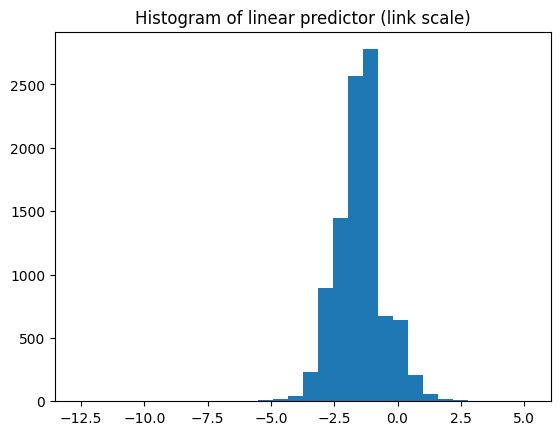

In [81]:
# 11) hist(predict(credit_glm0))  # default in R is on link scale
lin_pred = credit_glm0.predict(credit_train, linear=True)
plt.figure()
plt.hist(lin_pred, bins=30)
plt.title("Histogram of linear predictor (link scale)")
plt.show()


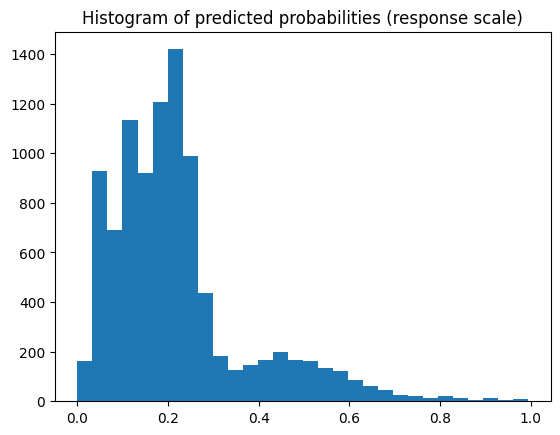

In [82]:
# 12) pred_resp <- predict(credit_glm0, type='response'); hist(pred_resp)
pred_resp = credit_glm0.predict(credit_train)  # response/probability scale
plt.figure()
plt.hist(pred_resp, bins=30)
plt.title("Histogram of predicted probabilities (response scale)")
plt.show()



The value 0.5 is called cut-off probability. You can choose the cut-off probability based on mis-classification rate, cost function, etc. In this case, the cost function can indicate the trade off between the risk of giving loan to someone who cannot pay (predict 0, truth 1), and risk of rejecting someone who qualifys (predict 1, truth 0).

These tables illustrate the impact of choosing different cut-off probability. Choosing a large cut-off probability will result in few cases being predicted as 1, and chossing a small cut-off probability will result in many cases being predicted as 1

In [84]:
%%shell
jupyter nbconvert --to html ///content/4_A_Logistic_regression_and_prediction.ipynb

[NbConvertApp] Converting notebook ///content/4_A_Logistic_regression_and_prediction.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 380481 bytes to /content/4_A_Logistic_regression_and_prediction.html
